


![image](https://user-images.githubusercontent.com/16392542/77208906-224aa500-6aba-11ea-96bd-e81806074030.png)







# Quick Start 

[AutoGluon](https://autogluon.mxnet.io/#) enables easy-to-use and easy-to-extend AutoML with a focus on deep learning and real-world applications spanning image, text, or tabular data. Intended for both ML beginners and experts, AutoGluon enables you to:

* Quickly prototype deep learning solutions for your data with few lines of code.

* Leverage automatic hyperparameter tuning, model selection / architecture search, and data processing.

* Automatically utilize state-of-the-art deep learning techniques without expert knowledge.

* Easily improve existing bespoke models and data pipelines, or customize AutoGluon for your use-case.

This Tutorial has two parts
1. **Search Space and Decorator**

2. **MNIST Training in PyTorch  (HPO)**



# 0. Installation

Run the following commands to install AutoGluon. 

```
pip install --upgrade mxnet
pip install autogluon
```

# 1. Search Space and Decorator

This section explains the supported search spaces and how to use them, including simple search spaces (Int, Real, and Categorical) and nested search spaces (Categorical, List, Dict). Each search space describes the set of possible values for a hyperparameter, from which the searcher will try particular values during hyperparameter optimization. AutoGluon also enables search spaces in user-defined objects using the decorator ag.obj and user-defined functions using the decorator `ag.func`.


## 1.1 Search Space

### Simple Search Space

In [6]:
import autogluon as ag


#### Integer Space :class:`autogluon.space.Int`

An integer is chosen between lower and upper value during the
searcher sampling.

In [7]:
a = ag.space.Int(lower=0, upper=10)
print(a)

Int: lower=0, upper=10


In [9]:
a.rand

10

#### Real Space :class:`autogluon.space.Real`

A real number is chosen between lower and upper value during the
searcher sampling.


In [10]:
b = ag.space.Real(lower=1e-4, upper=1e-2)
print(b)

Real: lower=0.0001, upper=0.01


In [5]:
c = ag.space.Real(lower=1e-4, upper=1e-2, log=True)
print(c)

Real: lower=0.0001, upper=0.01


#### Categorical Space :class:`autogluon.space.Categorical`

Categorical Space chooses one value from all the possible values during
the searcher sampling.

In [11]:
d = ag.space.Categorical('Monday', 'Tuesday', 'Wednesday')
print(d)

Categorical['Monday', 'Tuesday', 'Wednesday']


In [12]:
d.rand

'Wednesday'

## Nested Search Space

#### Categorical Space :class:`autogluon.space.Categorical`

Categorical Space can also be used as a nested search space.
For an example, see NestedExampleObj_.


#### List Space :class:`autogluon.space.List`

List Space returns a list of sampled results.

In this example, the first element of the list is a Int Space sampled
from 0 to 3, and the second element is a Categorical Space sampled
from the choices of `'alpha'` and `'beta'`.

In [13]:
f = ag.space.List(
        ag.space.Int(0, 3),
        ag.space.Categorical('alpha', 'beta'),
    )
print(f)

List[Int: lower=0, upper=3, Categorical['alpha', 'beta']]


Get one example configuration:

In [28]:
f.rand

[2, 'beta']

#### Dict Space :class:`autogluon.space.Dict`

Dict Space returns a dict of sampled results.

Similar to List Space, the resulting configuraton of Dict is
a dict. In this example, the value of `'key1'` is sampled from
a Categorical Space with the choices of `'alpha'` and `'beta'`,
and the value of `'key2'` is sampled from an Int Space between
0 and 3.

In [14]:
g = ag.space.Dict(
        key1=ag.space.Categorical('alpha', 'beta'),
        key2=ag.space.Int(0, 3),
        key3='constant'
    )
print(g)

Dict{'key1': Categorical['alpha', 'beta'], 'key2': Int: lower=0, upper=3, 'key3': 'constant'}


In [15]:
g.rand

{'key1': 'beta', 'key2': 1, 'key3': 'constant'}

## 1.2 Decorators for Searchbale Object and Customized Training Scripts

In this section, we show how to insert search space into customized objects and
training functions.

### Searchable Space in Customized Class :func:`autogluon.obj`

In AutoGluon searchable object can be returned by a user defined class with a decorator.

In [16]:
@ag.obj(

    name=ag.space.Categorical('auto', 'gluon'),
    static_value=10,
    rank=ag.space.Int(2, 5),
)
class MyObj:
    def __init__(self, name, rank, static_value):
        self.name = name
        self.rank = rank
        self.static_value = static_value
    def __repr__(self):
        repr = 'MyObj -- name: {}, rank: {}, static_value: {}'.format(
                self.name, self.rank, self.static_value)
        return repr
h = MyObj()
print(h)

AutoGluonObject -- MyObj


In [17]:
h.rand

MyObj -- name: gluon, rank: 3, static_value: 10

### Customized Train Script Using :func:`autogluon.args`

`train_func` is where to put your model training script, which takes in various keyword `args` as its hyperparameters and reports the performance of the trained model using the provided `reporter`. Here, we show a dummy train_func that simply prints these objects.

In [19]:
@ag.args(
    a=ag.space.Int(1, 10),
    b=ag.space.Real(1e-3, 1e-2),
    c=ag.space.Real(1e-3, 1e-2, log=True),
    d=ag.space.Categorical('a', 'b', 'c', 'd'),
    e=ag.space.Bool(),
    f=ag.space.List(
            ag.space.Int(1, 2),
            ag.space.Categorical(4, 5),
        ),
    g=ag.space.Dict(
            a=ag.Real(0, 10),
            obj=MyObj(),
        ),
    h=ag.space.Categorical('test', MyObj()),
)
def train_fn(args, reporter):
    print('args: {}'.format(args))

### Create Searcher and Sample a Configuration

In this section, we create a Searcher object, which orchestrates a particular hyperparameter-tuning strategy.


#### Create a Searcher and Sample Configuration

In [20]:
searcher = ag.searcher.RandomSearcher(train_fn.cs)
config = searcher.get_config()
print(config)

{'a': 6, 'b': 0.0055, 'c': 0.0031622777, 'd.choice': 0, 'e': 0, 'f.0': 2, 'f.1.choice': 0, 'g.a': 5.0, 'g.obj.name.choice': 0, 'g.obj.rank': 4, 'h.1.name.choice': 0, 'h.1.rank': 4, 'h.choice': 0}


#### Run one training job with the sampled configuration:

In [21]:
train_fn(train_fn.args, config)

args: {'a': 6, 'b': 0.0055, 'c': 0.0031622777, 'd': 'a', 'e': 0, 'f': [2, 4], 'g': {'a': 5.0, 'obj': MyObj -- name: auto, rank: 4, static_value: 10}, 'h': 'test', '_default_config': {}}



---

# 2. MNIST Training in PyTorch  (HPO)


In this tutorial, we demonstrate how to do Hyperparameter Optimization (HPO) using AutoGluon with PyTorch.
AutoGluon is a framework agnostic HPO toolkit, which is compatible with any training code written in python. The PyTorch code used in this tutorial is adapted from this [git repo](https://github.com/kuangliu/pytorch-cifar). In your applications, this code can be replaced with your own PyTorch code.

Import the packages:

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

## Start with an MNIST Example

### Data Transforms

We first apply standard image transforms to our training and validation data:

In [24]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Main Training Loop

The fol#lowing `train_mnist` function represents normal training code a user would write for
training on MNIST dataset. Python users typically use an argparser to conveniently
change default values. The only additional argument you need to add to your existing python function is a reporter object that is used to store performance achieved under different hyperparameter settings.

In [25]:
def train_mnist(args, reporter):
    # get variables from args
    lr = args.lr
    wd = args.wd
    epochs = args.epochs
    net = args.net
    print('lr: {}, wd: {}'.format(lr, wd))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model
    net = net.to(device)

    if device == 'cuda':
        net = nn.DataParallel(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=wd)

    # datasets and dataloaders
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    # Training
    def train(epoch):
        net.train()
        train_loss, correct, total = 0, 0, 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    def test(epoch):
        net.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        # 'epoch' reports the number of epochs done
        reporter(epoch=epoch+1, accuracy=acc)

    for epoch in tqdm(range(0, epochs)):
        train(epoch)
        test(epoch)

## AutoGluon HPO

In this section, we cover how to define a searchable network architecture, convert the training function to be searchable, create the scheduler, and then launch the experiment.

### Define a Searchable Network Achitecture

Let's define a 'dynamic' network with searchable configurations by simply adding a decorator :func:`autogluon.obj`. In this example, we only search two arguments `hidden_conv` and
`hidden_fc`, which represent the hidden channels in convolutional layer and fully connected layer. 
More info about searchable space is available at :meth:`autogluon.space`.

In [26]:
import autogluon as ag

@ag.obj(
    hidden_conv=ag.space.Int(6, 12),
    hidden_fc=ag.space.Categorical(80, 120, 160),
)
class Net(nn.Module):
    def __init__(self, hidden_conv, hidden_fc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_conv, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_conv, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, hidden_fc)
        self.fc2 = nn.Linear(hidden_fc, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Convert the Training Function to Be Searchable

We can simply add a decorator :func:`autogluon.args` to convert the `train_mnist` function argument values to be tuned by AutoGluon's hyperparameter optimizer. In the example below, we specify that the lr argument is a real-value that should be searched on a log-scale in the range 0.01 - 0.2. Before passing lr to your train function, AutoGluon always selects an actual floating point value to assign to lr so you do not need to make any special modifications to your existing code to accommodate the hyperparameter search.

In [27]:
@ag.args(
    lr = ag.space.Real(0.01, 0.2, log=True),
    wd = ag.space.Real(1e-4, 5e-4, log=True),
    net = Net(),
    epochs=5,
)
def ag_train_mnist(args, reporter):
    return train_mnist(args, reporter)

### Create the Scheduler and Launch the Experiment

For hyperparameter tuning, AutoGluon provides a number of different schedulers:

* FIFOScheduler: Each training jobs runs for the full number of epochs

* HyperbandScheduler: Uses successive halving and Hyperband scheduling in order to stop unpromising jobs early, so that the available budget is allocated more efficiently

Each scheduler is internally configured by a searcher, which determines the choice of hyperparameter configurations to be run. The default searcher is random: configurations are drawn uniformly at random from the search space.



In [28]:
myscheduler = ag.scheduler.FIFOScheduler(ag_train_mnist,
                                         resource={'num_cpus': 4, 'num_gpus': 1},
                                         num_trials=2,
                                         time_attr='epoch',
                                         reward_attr="accuracy")
print(myscheduler)


FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.55.92/2598/1' processes=1 threads=64, memory=267.40 GB>, Resource: NodeResourceManager(64 CPUs, 1 GPUs))
})



In [29]:
myscheduler.run()
myscheduler.join_jobs()

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


lr: 0.0447213595, wd: 0.0002236068




lr: 0.028245913732173278, wd: 0.00017160776862349322


We plot the test accuracy achieved over the course of training under each hyperparameter configuration that AutoGluon tried out (represented as different colors).

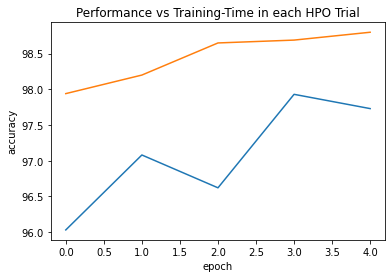

The Best Configuration and Accuracy are: {'lr': 0.028245913732173278, 'net.hidden_conv': 11, 'net.hidden_fc.choice': 0, 'wd': 0.00017160776862349322}, 98.8


In [30]:
myscheduler.get_training_curves(plot=True,use_legend=False)
print('The Best Configuration and Accuracy are: {}, {}'.format(myscheduler.get_best_config(),
                                                               myscheduler.get_best_reward()))

### **There are more advanced features. Please refer to [AutoGluon homepage](https://autogluon.mxnet.io/tutorials/torch/hpo.html)**